# Classification task using pytorch with CIFAR-10 Dataset

In [176]:
!nvidia-smi

Sat Nov 18 05:50:01 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0    29W /  70W |   1749MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### I. Set up

##### Import neccessary libraries and modules

In [177]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10
from torchsummary import summary

##### Setting cuda device for pytorch

In [178]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


##### Pre-download CIFAR10 dataset

In [179]:
%%shell

DATA_DIR='data'

if [ ! -d $DATA_DIR ]; then
  mkdir $DATA_DIR
  cd /content/data
  wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
  tar -xzvf cifar-10-python.tar.gz
  rm -f cifar-10-python.tar.gz
else
  echo "Directory $DATA_DIR already exists."
fi

Directory data already exists.


### II. Data preparation and preprocessing


##### Class called `Dataset` that is designed to handle the loading and processing of a dataset, specifically for the CIFAR-10 dataset. CIFAR-10 is a dataset of 60,000 32x32 color images in 10 different classes.

1. **Initialization (`__init__` method):**
   - The class has an `__init__` method, which initializes some attributes of the class.
   - It sets up a data transformation using the `transforms.Compose` class from the `torchvision.transforms` module. This transformation includes converting images to tensors and normalizing them.
   - It initializes attributes for training, validation, and test datasets, as well as corresponding data loaders, all set to `None` initially.

2. **Loading Datasets (`__load_dataset` method):**
   - There is a private method named `__load_dataset` that initializes the training and test datasets using the CIFAR-10 dataset. The CIFAR-10 dataset is a dataset of 60,000 32x32 color images in 10 different classes, with 6,000 images per class.
   - The method takes a `data_dir` parameter, which is the directory where the dataset is located.

3. **Splitting the Training Dataset (`__split_train_dataset` method):**
   - Another private method, `__split_train_dataset`, is responsible for splitting the training dataset into training and validation sets. It uses the `random_split` function from PyTorch to achieve this.

4. **Getting Dataset Shape (`__get_shape` method):**
   - There's a method named `__get_shape` that takes a dataset loader as a parameter and returns the shape of the input and label tensors for the first batch. It converts the tensors to NumPy arrays before retrieving their shapes.

5. **Creating Data Loaders (`__data_loader` method):**
   - The `__data_loader` method sets up data loaders for the training, validation, and test datasets using the `DataLoader` class from PyTorch.

6. **Displaying Dataset Information (`__dataset_info` method):**
   - The `__dataset_info` method prints information about the datasets, such as class names, sizes, batch sizes, and input/label shapes.

7. **Execution Method (`execute` method):**
   - The `execute` method is intended to be called to perform the complete setup and information retrieval. It takes parameters for the data directory (`data_dir`), batch size, and validation split.
   - It calls the private methods in sequence to load the dataset, split it, create data loaders, display dataset information, and finally returns the training, validation, and test data loaders.

In [180]:
class Dataset:
    def __init__(self):
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
        ])

        self.train_dataset = None
        self.val_dataset = None
        self.test_dataset = None

        self.train_loader = None
        self.val_loader = None
        self.test_loader = None


    def __load_dataset(self, data_dir):
        self.train_dataset = CIFAR10(
            root=data_dir,
            train=True,
            download=False,
            transform=self.transform
        )
        self.test_dataset = CIFAR10(
            root=data_dir,
            train=False,
            download=False,
            transform=self.transform
        )


    def __split_train_dataset(self, val_split):
        val_size = int(val_split * len(self.train_dataset))
        train_size = int((1 - val_split) * len(self.train_dataset))

        self.train_dataset, self.val_dataset = random_split(
            self.train_dataset, [train_size, val_size]
        )


    def __get_shape(self, dataset_loader):
        for idx, (inputs, labels) in enumerate(dataset_loader):
          inputs = np.array(inputs)
          labels = np.array(labels)
          return inputs.shape, labels.shape


    def __data_loader(self, batch_size, num_workers):
        self.train_loader = DataLoader(
            dataset=self.train_dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            shuffle=True
        )
        self.val_loader = DataLoader(
            dataset=self.val_dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            shuffle=False
        )
        self.test_loader = DataLoader(
            dataset=self.test_dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            shuffle=False
        )


    def __dataset_info(self):
        print("-"*50)
        print("--------------- Dataset Information --------------")
        print("-"*50)
        print(f"All classes : {self.test_dataset.classes}")
        print("       -----------------------------------       ")
        print(f"Train dataset size: {len(self.train_loader.dataset)}")
        print(f"Train batch size: {self.train_loader.batch_size}")
        print(f"Train input shape: {self.__get_shape(self.train_loader)[0]}")
        print(f"Train label shape: {self.__get_shape(self.train_loader)[1]}")
        print("       -----------------------------------       ")
        print(f"Validation dataset size: {len(self.val_loader.dataset)}")
        print(f"Validation batch size: {self.val_loader.batch_size}")
        print(f"Validation input shape: {self.__get_shape(self.val_loader)[0]}")
        print(f"Validation label shape: {self.__get_shape(self.val_loader)[1]}")
        print("       -----------------------------------       ")
        print(f"Test dataset size: {len(self.test_loader.dataset)}")
        print(f"Test batch size: {self.test_loader.batch_size}")
        print(f"Test input shape: {self.__get_shape(self.test_loader)[0]}")
        print(f"Test label shape: {self.__get_shape(self.test_loader)[1]}")
        print("-"*50)
        print("-"*50)
        print("-"*50)
        print()
        print()


    def execute(self, data_dir='./data', batch_size=128, val_split=0.1, num_workers=2):
        self.__load_dataset(data_dir)
        self.__split_train_dataset(val_split)
        self.__data_loader(batch_size, num_workers)
        self.__dataset_info()
        data_loader = (self.train_loader, self.val_loader, self.test_loader)
        data_size = (len(self.train_loader.dataset), len(self.val_loader.dataset), len(self.test_loader.dataset))
        return data_size, data_loader

##### Create an instance of dataset and run the `execute method`. The method returns the training, validation, and test data loaders

In [181]:
dataset = Dataset()
(train_size, val_size, test_size ),(train_loader, val_loader, test_loader) = dataset.execute()

--------------------------------------------------
--------------- Dataset Information --------------
--------------------------------------------------
All classes : ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
       -----------------------------------       
Train dataset size: 45000
Train batch size: 128
Train input shape: (128, 3, 32, 32)
Train label shape: (128,)
       -----------------------------------       
Validation dataset size: 5000
Validation batch size: 128
Validation input shape: (128, 3, 32, 32)
Validation label shape: (128,)
       -----------------------------------       
Test dataset size: 10000
Test batch size: 128
Test input shape: (128, 3, 32, 32)
Test label shape: (128,)
--------------------------------------------------
--------------------------------------------------
--------------------------------------------------




### III/ Create model

##### Create a convolutional neural network (CNN) using PyTorch's `nn.Module` class. The network consists of convolutional layers, activation functions (ReLU), max-pooling layers, and fully connected (linear) layers.

1. **Convolutional Layers (First Block):**
   - Input: 3 channels (for RGB images).
   - First convolutional layer: 3 input channels, 32 output channels, 3x3 kernel, padding of 1.
   - ReLU activation function.
   - Second convolutional layer: 32 input channels, 64 output channels, 3x3 kernel, stride of 1, padding of 1.
   - ReLU activation function.
   - Max pooling layer with a 2x2 kernel and stride of 2, reducing spatial dimensions by half.
   - Output size after this block: 64 channels, 16x16 spatial dimensions.

2. **Convolutional Layers (Second Block):**
   - Third convolutional layer: 64 input channels, 128 output channels, 3x3 kernel, stride of 1, padding of 1.
   - ReLU activation function.
   - Fourth convolutional layer: 128 input channels, 128 output channels, 3x3 kernel, stride of 1, padding of 1.
   - ReLU activation function.
   - Max pooling layer with a 2x2 kernel and stride of 2, reducing spatial dimensions by half.
   - Output size after this block: 128 channels, 8x8 spatial dimensions.

3. **Convolutional Layers (Third Block):**
   - Fifth convolutional layer: 128 input channels, 256 output channels, 3x3 kernel, stride of 1, padding of 1.
   - ReLU activation function.
   - Sixth convolutional layer: 256 input channels, 256 output channels, 3x3 kernel, stride of 1, padding of 1.
   - ReLU activation function.
   - Max pooling layer with a 2x2 kernel and stride of 2, reducing spatial dimensions by half.
   - Output size after this block: 256 channels, 4x4 spatial dimensions.

4. **Fully Connected Layers:**
   - `nn.Flatten()` is used to flatten the spatial dimensions into a 1D tensor.
   - `nn.Dropout()` is used to dropout some paramters to reduce the overfitting effect
   - First fully connected layer: 256 * 4 * 4 input features, 1024 output features.
   - ReLU activation function.
   - `nn.Dropout()` is used to dropout some paramters to reduce the overfitting effect
   - Second fully connected layer: 1024 input features, 512 output features.
   - ReLU activation function.
   - `nn.Dropout()` is used to dropout some paramters to reduce the overfitting effect
   - Third fully connected layer: 512 input features, 10 output features (for classification into 10 classes).

5. **Forward Method:**
   - The `forward` method defines the forward pass of the network. It applies the layers defined in the constructor in sequence to the input `x`.

In [182]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.network = nn.Sequential(
            # Convolutional Layers (First Block)
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            # Convolutional Layers (Second Block)
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            # Convolutional Layers (Third Block)
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            # Fully connected layers
            nn.Flatten(),
            nn.Dropout(),
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(512, 10)
        )


    def forward(self, x):
        return self.network(x)

##### Show summary of the model

In [183]:
net = Net()
net = net.to(device)
summary(net, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          18,496
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
             ReLU-14            [-1, 25

### III/ Training the model

##### Training Configuration

In [184]:
LEARNING_RATE = 0.001
EPOCHS = 15

net = Net()
net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE, amsgrad=True)

train_loss_list = []
val_loss_list = []
accuracy_list = []

val_loss_min = np.Inf

##### Func

In [185]:
def cal_accuracy(outputs, labels):
    predicted = torch.max(outputs.data, 1)[1]
    return (predicted == labels).sum().item()

@torch.no_grad()
def evaluate(model, dataset_loader):
    model.eval()
    correct = 0.0
    val_loss = 0.0
    for inputs, labels in dataset_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        val_loss += loss.item() * inputs.size(0)

        correct += cal_accuracy(outputs, labels)
    return val_loss, correct

##### Training process

In [186]:
net.train()
for epoch in range(EPOCHS):
    train_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)

    val_loss, correct = evaluate(net, val_loader)

    train_loss = train_loss / train_size
    val_loss = val_loss / val_size
    accuracy = correct / val_size

    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    accuracy_list.append(accuracy)

    print(f"Epoch: {epoch + 1} \t Train Loss: {train_loss:.6f} \t Val loss: {val_loss:.6f} \t Val Accuracy: {accuracy:.6f} ")
    if val_loss <= val_loss_min:
        torch.save(net.state_dict(), "cifar10-cnn.pt")
        val_loss_min = val_loss
print(f"------------------------------------ Finished Training ------------------------------------")

Epoch: 1 	 Train Loss: 1.780971 	 Val loss: 1.413771 	 Val Accuracy: 0.486600 
Epoch: 2 	 Train Loss: 1.173294 	 Val loss: 1.081831 	 Val Accuracy: 0.613800 
Epoch: 3 	 Train Loss: 0.863451 	 Val loss: 0.876340 	 Val Accuracy: 0.703800 
Epoch: 4 	 Train Loss: 0.669085 	 Val loss: 0.729635 	 Val Accuracy: 0.748800 
Epoch: 5 	 Train Loss: 0.528966 	 Val loss: 0.737291 	 Val Accuracy: 0.742800 
Epoch: 6 	 Train Loss: 0.403280 	 Val loss: 0.760187 	 Val Accuracy: 0.761600 
Epoch: 7 	 Train Loss: 0.295304 	 Val loss: 0.803266 	 Val Accuracy: 0.756000 
Epoch: 8 	 Train Loss: 0.209344 	 Val loss: 0.903136 	 Val Accuracy: 0.766000 
Epoch: 9 	 Train Loss: 0.156680 	 Val loss: 1.002177 	 Val Accuracy: 0.762000 
Epoch: 10 	 Train Loss: 0.117439 	 Val loss: 1.094507 	 Val Accuracy: 0.764400 
Epoch: 11 	 Train Loss: 0.107967 	 Val loss: 1.130130 	 Val Accuracy: 0.763800 
Epoch: 12 	 Train Loss: 0.079503 	 Val loss: 1.311734 	 Val Accuracy: 0.748600 
Epoch: 13 	 Train Loss: 0.074053 	 Val loss: 1.27

### IV/ Evaluation

##### Show the figure of accuracy vs number of epochs

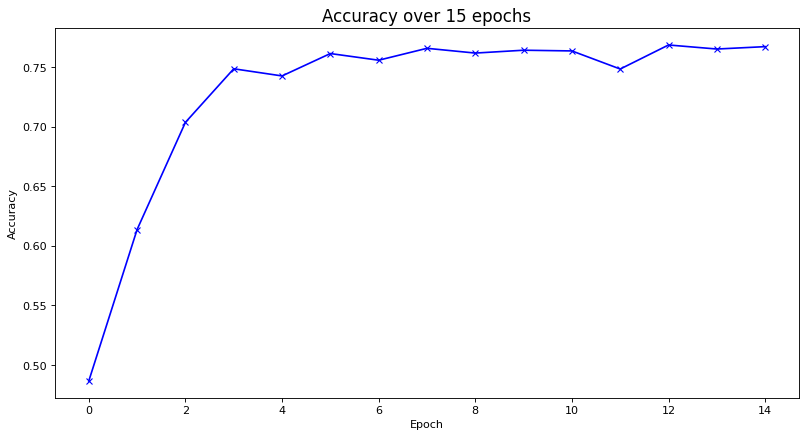

In [187]:
figure(figsize=(12, 6), dpi=80)
plt.title(f"Accuracy over {EPOCHS} epochs", size=15)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.plot(accuracy_list, "-bx")
plt.show()

##### Show the figure of loss vs number of epochs

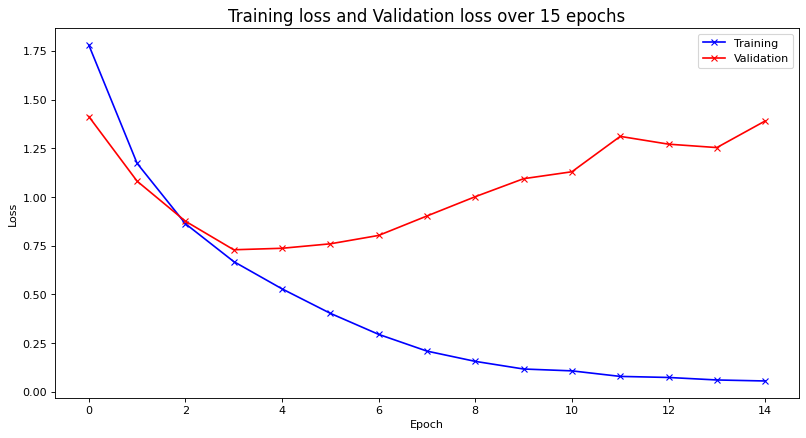

In [188]:
figure(figsize=(12, 6), dpi=80)
plt.title(f"Training loss and Validation loss over {EPOCHS} epochs", size=15)
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.plot(train_loss_list,"-bx")
plt.plot(val_loss_list, "-rx")
plt.legend(['Training', 'Validation'])
plt.show()

##### Evaluate the model on test dataset

In [192]:
final_model = Net()
final_model.to(device)
final_model.load_state_dict(torch.load("cifar10-cnn.pt"))
correct = 0

_, correct = evaluate(final_model, test_loader)
print(f"Accuracy on test dataset {correct * 100 / test_size}%")

Accuracy on test dataset 75.22%
